In [54]:
import numpy as np
import matplotlib.pyplot as plt

### Root-Finding

In [1]:
#Monthly payment input
def Monthly_Payment():
    h = True
    while h == True:
        try:
            mp = float(input("What monthly payment can you afford? $"))
            if mp > 0:
                h = False
                return mp
            else:
                print("The input must be positive.")
        except ValueError:
            print("Please do no include punctuation or letters in your input.")

globmp = Monthly_Payment()

#Interest rate optimization function
def interest(x):
    global globmp
    return ((globmp)/x)*(1-((1+x)**-360)) - 300000

#derivative of interest rate function
def d_interest(x):
    '''First derivative of interest(x)'''
    global globmp
    return -globmp*(x**(-2)) - ((-360*(globmp))*(x**(-1))*((1 + x)**(-361)) - globmp*(x**(-2))*((1+x)**(-360)))

What monthly payment can you afford? $1550


In [2]:
#Modify Newton to use interest/d_interest correctly

def interest_Newton(f, f1, p_0, TOL, NMAX):
    '''calculates maximum interest rate given monthly payment input from interest/d_interest
    using the ordinary annuity equation'''
    
    i = 1
    while i <= NMAX:
        p = p_0 - (f(p_0)/f1(p_0))
        if abs(p - p_0) < TOL:
            return "The maximum interest rate you can afford is %.2f%%" %((12*p)*100), "The method was successful after %s iterations." %i
        i += 1
        p_0 = p
    return "The method failed after %s iterations" %NMAX

print(interest_Newton(interest, d_interest, 0.0025, 1e-6, 100))

('The maximum interest rate you can afford is 4.67%', 'The method was successful after 4 iterations.')


[0.003218595953531625, 0.0017413230707296924, 0.00035868973581285914, 1.202562987072213e-05, 1.2822409493559728e-08]


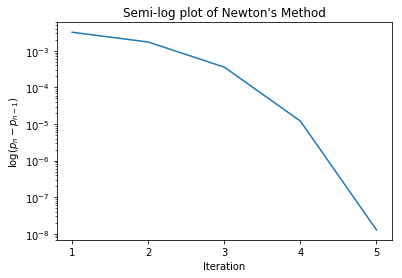

In [65]:
def logplot_Newton(f, f1, p_0, TOL, NMAX):
    '''Creates a plot showing convegence of Newtons method'''
    
    y_vals = []
    x_vals = []
    
    i = 1
    while i <= NMAX:
        p = p_0 - (f(p_0)/f1(p_0))
        y_vals.append(abs(p - p_0))
        x_vals.append(i)

        if abs(p -p_0) < TOL:
            print(y_vals)
            plt.plot(x_vals, y_vals)
            plt.yscale('log')
            plt.xticks(np.arange(1, max(x_vals) + 1, 1))
            plt.xlabel("Iteration")
            plt.ylabel(r"$\log(p_{n} - p_{n-1})$")
            plt.title("Semi-log plot of Newton\'s Method")
            plt.show()
            return
        
        i += 1
        p_0 = p           
    return "The method was unsuccesful."

logplot_Newton(interest, d_interest, 0.0025, 1e-6, 100)

In [4]:
payments = [1000, 1500, 2000, 2500]
rates = [1.25, 4.39, 7.02, 9.40]

In [66]:
test_vals = [1100, 1250, 1400, 1600, 1750, 1900, 2100, 2250, 2400]
real_vals = [1.94, 2.91, 3.81, 4.94, 5.75, 6.52, 7.51, 8.23, 8.94]

('The maximum interest rate you can afford is 9.40%', 'The method was successful after 5 iterations.')


### Interpolation Methods

In [6]:
#Neville's Method function
#vec_x is a vector of x values, f_x is the value of the function at each x in vec_x

def interest_Neville(x, vec_x, f_x):
    '''Computes interpolation for a point x using Neville's Method given a vector of x values vec_x
    and a vector, f_x, of corresponding y values for each value in vec_x'''
    
    n = np.size(vec_x) - 1
    Q_table = np.zeros((n+1, n+1)) #create an n x n matrix of zeros
    
    for i in np.arange(0, n+1): #set the vector f_x as the first column in Q_table
        Q_table[i][0] = f_x[i]
        
    for j in np.arange(1, n+1):
        for i in np.arange(j, n+1): #set the value for Q_table[i][j]
            Q_table[i][j] = (((x - vec_x[i-j])*Q_table[i][j-1]) - ((x - vec_x[i])*Q_table[i-1][j-1]))/(vec_x[i] - vec_x[i - j])
            
    #output the approximation and the Q_table
    return Q_table[n][n]

In [7]:
#change cubic spline for interest rate

#natural cubic splines

def interest_N_cubic_spline(y, x, a):
    '''returns the interpolated value, y,  of the natural cubic spline
    interpolant for a function'''

    n = np.size(x) - 1
    
    #set size of different variables
    h = np.zeros((n, 1))
    alpha = np.zeros((n, 1))
    l = np.zeros((n+1, 1))
    mu = np.zeros((n+1, 1))
    z = np.zeros((n+1, 1))
    c = np.zeros((n+1, 1))
    b = np.zeros((n+1, 1))
    d = np.zeros((n+1, 1))
    
    #calculate coefficients
    for i in np.arange(n):
        h[i] = x[i+1] - x[i]
    
    for i in np.arange(1, n):
        alpha[i] = (3/h[i])*(a[i+1] - a[i]) - (3/h[i-1])*(a[i] - a[i-1])
    
    l[0] = 1
    mu[0] = 0
    z[0] = 0
    
    for i in np.arange(1, n):
        l[i] = 2*(x[i+1] - x[i-1]) - h[i-1]*mu[i-1]
        mu[i] = h[i]/l[i]
        z[i] = (alpha[i] - h[i-1]*z[i-1])/l[i]
        
    l[n] = 1
    z[n] = 0
    c[n] = 0
    
    for j in np.arange(n-1, -1, -1):
        c[j] = z[j] - mu[j]*c[j+1]
        b[j] = ((a[j+1] - a[j])/h[j]) - ((h[j]*(c[j+1] + 2*c[j]))/3)
        d[j] = (c[j+1] - c[j])/(3*h[j])
     
    #get coefficients sorted for output
    a_coeffs = []
    b_coeffs = []
    c_coeffs = []
    d_coeffs = []
    
    for j in np.arange(0, n):
        a_coeffs.append(a[j])
        b_coeffs.append(b[j])
        c_coeffs.append(c[j])
        d_coeffs.append(d[j])
    
    #determine which coefficients to use and what to subtract
    interp_coeffs = []
    sub = 0
    for i in np.arange(n):
        if y > x[i] and y < x[i+1]:
            interp_coeffs.append(a_coeffs[i])
            interp_coeffs.append(b_coeffs[i])
            interp_coeffs.append(c_coeffs[i])
            interp_coeffs.append(d_coeffs[i])
            sub += x[i]
            
    #use interp_coefficients to calculate a final value
    interp_val = interp_coeffs[0]
    for i in np.arange(1, np.size(interp_coeffs)):
        interp_val += interp_coeffs[i]*((y-sub)**i)
    
    
    return np.round(interp_val, decimals=2)

### Error/Results

In [8]:
def error(real, interp):
    '''calculates the average absolute and relative error for interpolated values'''
    
    n = np.size(real) - 1
    e_abs = []
    e_rel = []
    
    for i in np.arange(n):
        x = abs(real[i] - interp[i])
        e_abs.append(x)
        e_rel.append(x/abs(real[i]))
    
    return "The average absolute error is: %.4f" %np.mean(e_abs), "The average relative error is: %.6f" %np.mean(e_rel)

In [9]:
#compute interpolation values for natural cubic spline
test_vals = [1100, 1250, 1400, 1600, 1750, 1900, 2100, 2250, 2400]
test_interests_cube = []

for i in test_vals:
    x = interest_N_cubic_spline(i, payments, rates)
    test_interests_cube.append(x)
    print("The interpolated interest rate for a monthly payment of $%.2f is: %.2f%%" %(i, x))   

The interpolated interest rate for a monthly payment of $1100.00 is: 1.90%
The interpolated interest rate for a monthly payment of $1250.00 is: 2.86%
The interpolated interest rate for a monthly payment of $1400.00 is: 3.80%
The interpolated interest rate for a monthly payment of $1600.00 is: 4.96%
The interpolated interest rate for a monthly payment of $1750.00 is: 5.76%
The interpolated interest rate for a monthly payment of $1900.00 is: 6.53%
The interpolated interest rate for a monthly payment of $2100.00 is: 7.51%
The interpolated interest rate for a monthly payment of $2250.00 is: 8.22%
The interpolated interest rate for a monthly payment of $2400.00 is: 8.93%


Text(0.5,1,'Cubic Spline')

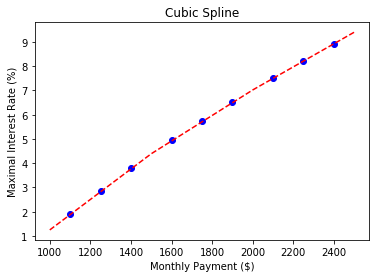

In [20]:
plt.plot(test_vals, test_interests_cube, 'bo', payments, rates, 'r--')
plt.xlabel('Monthly Payment ($)')
plt.ylabel('Maximal Interest Rate (%)')
plt.title('Cubic Spline')

In [11]:
#real values obtained from using test_vals in interest/d_interest/interest_Newton
real_interests = [1.94, 2.91, 3.81, 4.94, 5.75, 6.52, 7.51, 8.23, 8.94]

#compute errors for natural cubic spline
print(error(real_interests, test_interests_cube))

('The average absolute error is: 0.0188', 'The average relative error is: 0.006120')


In [12]:
#compute interpolation values for Neville
test_vals = [1100, 1250, 1400, 1600, 1750, 1900, 2100, 2250, 2400]
test_interests_Nev = []

for i in test_vals:
    x = interest_Neville(i, payments, rates)
    test_interests_Nev.append(x)
    print("The interpolated interest rate for a monthly payment of $%.2f is: %.2f%%" %(i, x))

The interpolated interest rate for a monthly payment of $1100.00 is: 1.93%
The interpolated interest rate for a monthly payment of $1250.00 is: 2.90%
The interpolated interest rate for a monthly payment of $1400.00 is: 3.81%
The interpolated interest rate for a monthly payment of $1600.00 is: 4.95%
The interpolated interest rate for a monthly payment of $1750.00 is: 5.75%
The interpolated interest rate for a monthly payment of $1900.00 is: 6.52%
The interpolated interest rate for a monthly payment of $2100.00 is: 7.51%
The interpolated interest rate for a monthly payment of $2250.00 is: 8.23%
The interpolated interest rate for a monthly payment of $2400.00 is: 8.93%


Text(0.5,1,"Neville's Method")

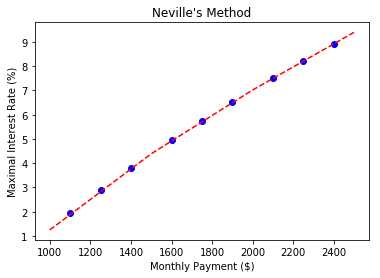

In [19]:
plt.plot(test_vals, test_interests_Nev, 'bo', payments, rates, 'r--')
plt.xlabel('Monthly Payment ($)')
plt.ylabel('Maximal Interest Rate (%)')
plt.title('Neville\'s Method')

In [25]:
#compute error for Neville
print(error(real_interests, test_interests_Nev))

('The average absolute error is: 0.0051', 'The average relative error is: 0.001456')
